(Temporary) upload file in Colab then specify path and filename

In [ ]:
!mkdir input
!mkdir output

url, filename = ("/content/input/bankst.jpg", "bankst.png") # IMAGE MUST BE JPG

mkdir: cannot create directory ‘input’: File exists
mkdir: cannot create directory ‘output’: File exists


# Setup

In [ ]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.8 MB/s eta 0:00:00


In [ ]:
import cv2
import torch
import urllib.request
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

Load a model (see [https://github.com/intel-isl/MiDaS/#Accuracy](https://github.com/intel-isl/MiDaS/#Accuracy) for an overview)

In [ ]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt
100%|██████████| 1.28G/1.28G [00:09<00:00, 150MB/s]


Move model to GPU if available

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

DPTDepthModel(
  (pretrained): Module(
    (model): VisionTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (patch_drop): Identity()
      (norm_pre): Identity()
      (blocks): Sequential(
        (0): Block(
          (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (attn): Attention(
            (qkv): Linear(in_features=1024, out_features=3072, bias=True)
            (q_norm): Identity()
            (k_norm): Identity()
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=1024, out_features=1024, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (ls1): Identity()
          (drop_path1): Identity()
          (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_featur

Load transforms to resize and normalize the image for large or small model

In [ ]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Load image and apply transforms

(-0.5, 1241.5, 678.5, -0.5)

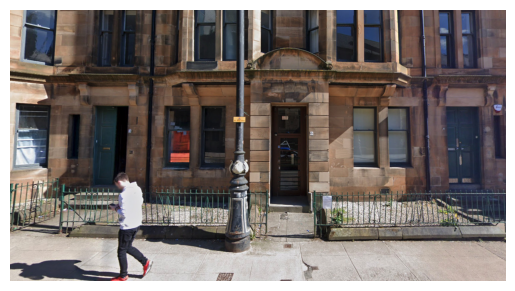

In [ ]:
img = cv2.imread(url)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Image as a numpy ndarray
input_batch = transform(img).to(device)
plt.imshow(img)
plt.axis('off')

Predict depths and resize to original resolution

In [ ]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

Show depth prediction

(679, 1242)

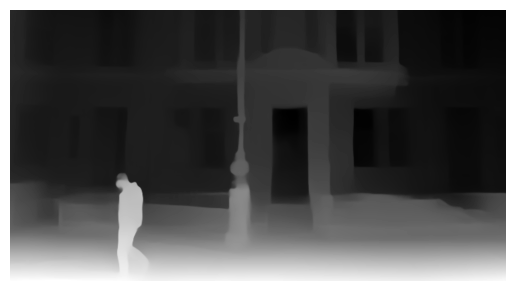

In [ ]:
plt.imshow(output, cmap='gray')
plt.axis('off')
output.shape

# Image segmentation
Set up image segmentation

In [ ]:
!pip install transformers
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation
from matplotlib import cm

processor = AutoImageProcessor.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")
model = Mask2FormerForUniversalSegmentation.from_pretrained("facebook/mask2former-swin-base-coco-panoptic")

preprocessor_config.json:   0%|          | 0.00/538 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/9.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/432M [00:00<?, ?B/s]

Reshape and normalise depth map (currently redundant)

In [ ]:
output_reshape = np.dstack((output, output, output)) # Convert to image with 3 dimensions
output_reshape = (output_reshape-np.min(output_reshape))/(np.max(output_reshape)-np.min(output_reshape))

Predict image segments

In [ ]:
img_pil = Image.open(url)

inputs = processor(img_pil, return_tensors='pt')

with torch.no_grad():
  outputs = model(**inputs)

prediction = processor.post_process_panoptic_segmentation(outputs, target_sizes=[img_pil.size[::-1]])[0]

`label_ids_to_fuse` unset. No instance will be fused.


Display image segments

<ipython-input-14-48b15c2a5c09>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = cm.get_cmap('viridis', torch.max(segmentation))


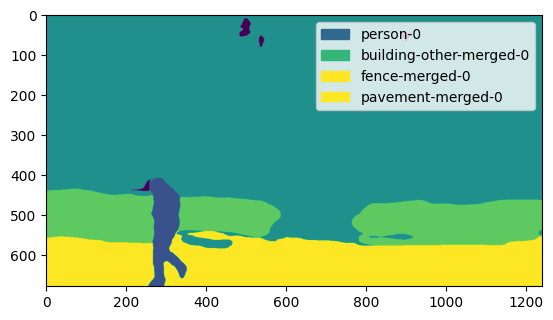

In [ ]:
from collections import defaultdict
import matplotlib.patches as mpatches

def draw_panoptic_segmentation(segmentation, segments_info):
    # get the used color map
    viridis = cm.get_cmap('viridis', torch.max(segmentation))
    fig, ax = plt.subplots()
    ax.imshow(segmentation)
    instances_counter = defaultdict(int)
    handles = []
    # for each segment, draw its legend
    for segment in segments_info:
        segment_id = segment['id']
        segment_label_id = segment['label_id']
        segment_label = model.config.id2label[segment_label_id]
        label = f"{segment_label}-{instances_counter[segment_label_id]}"
        instances_counter[segment_label_id] += 1
        color = viridis(segment_id)
        handles.append(mpatches.Patch(color=color, label=label))

    ax.legend(handles=handles)
draw_panoptic_segmentation(prediction['segmentation'], prediction['segments_info'])

Take each segment and create a mask

In [ ]:
# https://github.com/NielsRogge/Transformers-Tutorials/blob/master/Mask2Former/Inference_with_Mask2Former.ipynb

def get_mask(segment_id):
  mask = (prediction['segmentation'].numpy() == segment_id) # move to cell below
  visual_mask = (mask * 255).astype(np.uint8)
  visual_mask = Image.fromarray(visual_mask)
  return visual_mask

Create a dictionary with value PIL image of mask and corresponding depth value pair

In [ ]:
from scipy import stats

In [ ]:
def mask_generator():
    for segment_info in prediction['segments_info']:
        mask_pil = get_mask(segment_info['id'])
        mask_pil = mask_pil.convert('RGB')
        mask_pil = mask_pil.convert('L')
        depth = np.median(output[np.array(mask_pil)]) # To solve - better average depth calculation
        yield mask_pil, depth

Populate dictionary with details

In [ ]:
"""
mask_info = {}
for i, (mask_pil, depth) in enumerate(mask_generator()):
  mask_info[i] = [mask_pil, depth]
"""

'\nmask_info = {}\nfor i, (mask_pil, depth) in enumerate(mask_generator()):\n  mask_info[i] = [mask_pil, depth]\n'

Populate using list with details

In [ ]:
mask_info_list = []
for i, (mask_pil, depth) in enumerate(mask_generator()):
  mask_info_list.append([mask_pil, depth])

In [ ]:
def display_images(images, size=(50, 10)):
  fig, axes = plt.subplots(1, len(images), figsize=size)

  # Iterate through the images and display them
  for i, plane in enumerate(images):
      axes[i].imshow(plane)
      axes[i].axis('off')

  plt.show()

Sort the dictionary by depth ascending

In [ ]:
"""
mask_info = dict(sorted(mask_info.items(), key=lambda item: item[1][1]))

print("Average depths of segments in ascending order")
for mask in mask_info:
  print(mask_info[mask][1])
"""

'\nmask_info = dict(sorted(mask_info.items(), key=lambda item: item[1][1]))\n\nprint("Average depths of segments in ascending order")\nfor mask in mask_info:\n  print(mask_info[mask][1])\n'

Sort the list by depth ascending

In [ ]:
mask_info = sorted(mask_info_list, key=lambda x: x[1])
print("Average depths of segments in ascending order")
for mask in mask_info:
  print(mask[1])

Average depths of segments in ascending order
7.9246554
7.969194
7.9791064
7.984064


Display the masks

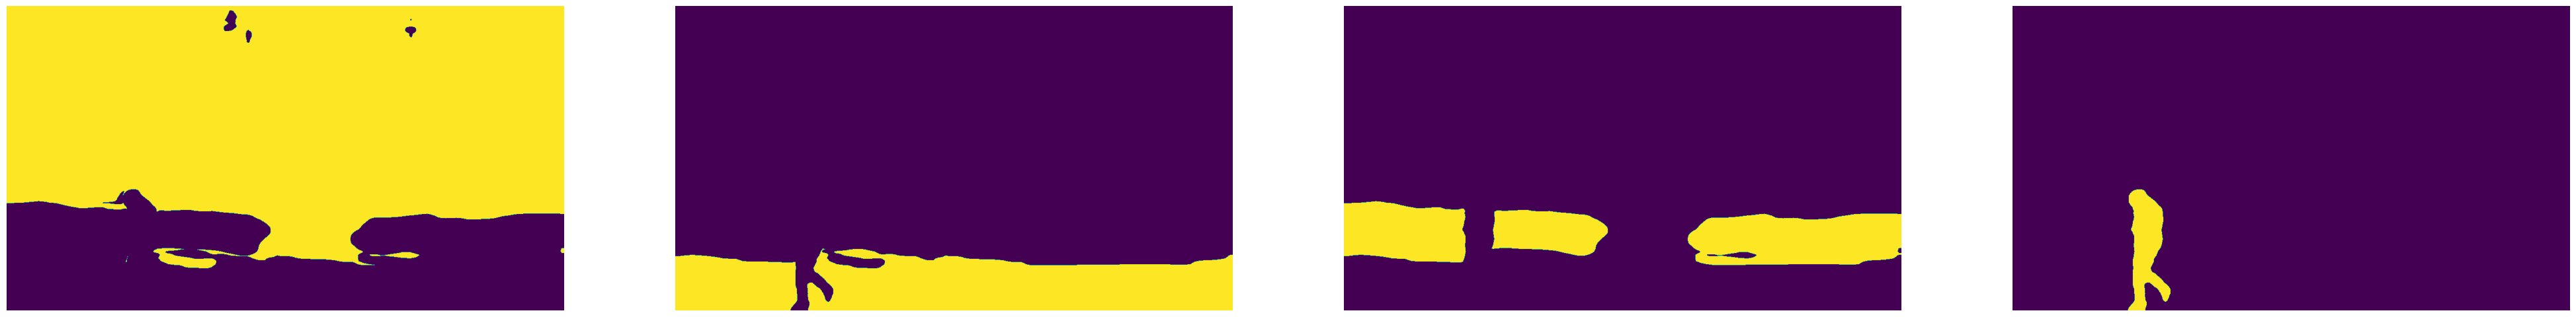

In [ ]:
display_images([mask[0] for mask in mask_info])

Reindex the dictionary according to the ascending depth

In [ ]:
"""
def reindex_dict(mask_info):
  i = 0
  new_dict = {}
  for mask in mask_info:
    new_dict[i] = mask_info[mask]
    i+=1
  return new_dict

mask_info = reindex_dict(mask_info)
# If we're reindexing the dictionary anyway according to ascending median depth then the dictionary becomes redundant
"""

"\ndef reindex_dict(mask_info):\n  i = 0\n  new_dict = {}\n  for mask in mask_info:\n    new_dict[i] = mask_info[mask]\n    i+=1\n  return new_dict\n\nmask_info = reindex_dict(mask_info)\n# If we're reindexing the dictionary anyway according to ascending median depth then the dictionary becomes redundant\n"

Create depth ranges to chop image into

In [ ]:
depth_ranges = [[mask_info[i][1], mask_info[i+1][1]] for i in range(len(mask_info)-1)]
print(depth_ranges)

[[7.9246554, 7.969194], [7.969194, 7.9791064], [7.9791064, 7.984064]]


(Not working) trying to create depth_planes list without duplicates in one iteration

In [ ]:
"""
depth_planes = []
for i, m in enumerate(mask_info):
  if depth_ranges[i][0] <= mask_info[m][1] <= depth_ranges[i][1]:
    mask_reshape = np.stack((mask_info[m][0], mask_info[m][0], mask_info[m][0]), axis=-1)
    depth_planes.append(np.where(mask_reshape, img, mask_reshape))

print("There are " + str(len(depth_planes)) + " depth planes" )
"""

'\ndepth_planes = []\nfor i, m in enumerate(mask_info):\n  if depth_ranges[i][0] <= mask_info[m][1] <= depth_ranges[i][1]:\n    mask_reshape = np.stack((mask_info[m][0], mask_info[m][0], mask_info[m][0]), axis=-1)\n    depth_planes.append(np.where(mask_reshape, img, mask_reshape))\n\nprint("There are " + str(len(depth_planes)) + " depth planes" )\n'

Chop the image into different depth levels

In [ ]:
depth_planes = []
for (a,b) in depth_ranges:
  for mask in mask_info:
    if a <= mask[1] <= b:
      mask_reshape = np.stack((mask[0], mask[0], mask[0]), axis=-1)
      depth_planes.append(np.where(mask_reshape, img, mask_reshape))
print("There are " + str(len(depth_planes)) + " depth planes" )
depth_planes.reverse()

There are 6 depth planes


(Temporary solution) remove duplicate planes

In [ ]:
unique_planes = []

for plane in depth_planes:
  if not any(np.array_equal(plane, unique) for unique in unique_planes):
    unique_planes.append(plane)
print(str(len(unique_planes)) + " unique depth planes")

4 unique depth planes


Display the different depth planes

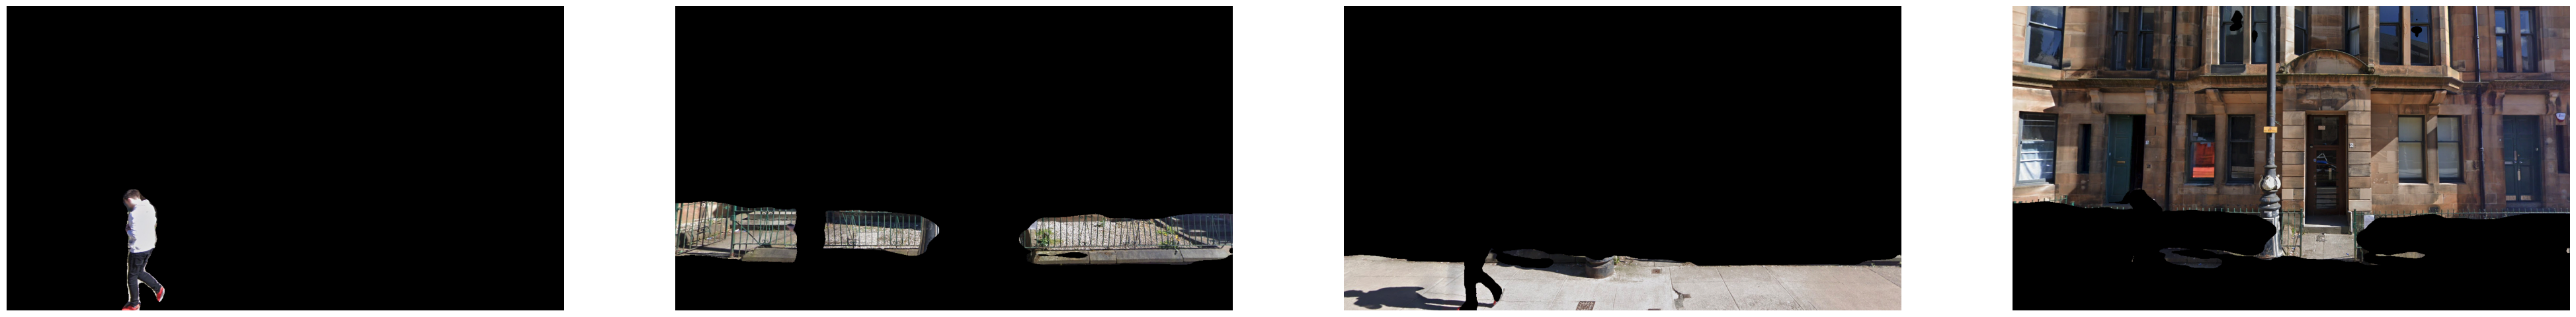

In [ ]:
display_images(unique_planes)

## Now we move to the inpainting pipeline

In [ ]:
!git clone https://github.com/loboere/latent-diffusion-inpainting-colab.git
%cd /content/latent-diffusion-inpainting-colab


Cloning into 'latent-diffusion-inpainting-colab'...
remote: Enumerating objects: 371, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 371 (delta 115), reused 111 (delta 111), pack-reused 214
Receiving objects: 100% (371/371), 39.02 MiB | 28.48 MiB/s, done.
Resolving deltas: 100% (151/151), done.
/content/latent-diffusion-inpainting-colab


In [ ]:
#@title Installation
!git clone https://github.com/CompVis/taming-transformers
!pip install -e ./taming-transformers
!pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops
!pip install transformers
!pip install open_clip_torch
!pip install autokeras
!pip install torchmetrics==0.11.4
!pip install pytorch-lightning==1.7.7
import sys
sys.path.append(".")
sys.path.append('./taming-transformers')
from taming.models import vqgan

Cloning into 'taming-transformers'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 1342 (delta 0), reused 1 (delta 0), pack-reused 1340
Receiving objects: 100% (1342/1342), 409.77 MiB | 33.74 MiB/s, done.
Resolving deltas: 100% (282/282), done.
Obtaining file:///content/latent-diffusion-inpainting-colab/taming-transformers
  Preparing metadata (setup.py) ... done
  Running setup.py develop for taming-transformers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.5/584.5 kB 10.9 MB/s eta 0:00:

In [ ]:
!pip install -qq torch==1.9.0 pytorch-lightning==1.7.7 aitextgen==0.6.0
from taming.models import vqgan

In [ ]:
model_path = "/content/latent-diffusion-inpainting-colab/models/ldm/inpainting_big"

In [ ]:
#@title Download model
%cd /content/latent-diffusion-inpainting-colab

import os
if os.path.isfile(f"{model_path}/latent_diffusion_txt2img_f8_large.ckpt"):
    print("Using saved model from Google Drive")
else:
    !wget -O $model_path/latent_diffusion_txt2img_f8_large.ckpt https://ommer-lab.com/files/latent-diffusion/nitro/txt2img-f8-large/model.ckpt

In [ ]:
#@title loading utils
import torch
from omegaconf import OmegaConf

from ldm.util import instantiate_from_config

In [ ]:
%cd /content/latent-diffusion

In [ ]:
#@title Import stuff
import argparse, os, sys, glob
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm.auto import tqdm, trange
tqdm_auto_model = __import__("tqdm.auto", fromlist=[None])
sys.modules['tqdm'] = tqdm_auto_model
from einops import rearrange
from torchvision.utils import make_grid
import transformers
import gc
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
from open_clip import tokenizer
import open_clip
import tensorflow as tf

In [ ]:
output.dtype

In [ ]:
#@title Load necessary functions
def preprocess_image(image_path):
    image = Image.open(image_path)
    if not image.mode == "RGB":
        image = image.convert("RGB")
    image = np.array(image).astype(np.uint8)
    image = (image/127.5 - 1.0).astype(np.float32)
    return image

def preprocess_mask(mask_path, h, w):
    mask = Image.open(mask_path).convert('1')
    mask_resize = mask.resize((w, h))
    return np.array(mask_resize).astype(np.float32)

def load_safety_model(clip_model):
    """load the safety model"""
    import autokeras as ak  # pylint: disable=import-outside-toplevel
    from tensorflow.keras.models import load_model  # pylint: disable=import-outside-toplevel
    from os.path import expanduser  # pylint: disable=import-outside-toplevel

    home = expanduser("~")

    cache_folder = home + "/.cache/clip_retrieval/" + clip_model.replace("/", "_")
    if clip_model == "ViT-L/14":
        model_dir = cache_folder + "/clip_autokeras_binary_nsfw"
        dim = 768
    elif clip_model == "ViT-B/32":
        model_dir = cache_folder + "/clip_autokeras_nsfw_b32"
        dim = 512
    else:
        raise ValueError("Unknown clip model")
    if not os.path.exists(model_dir):
        os.makedirs(cache_folder, exist_ok=True)

        from urllib.request import urlretrieve  # pylint: disable=import-outside-toplevel

        path_to_zip_file = cache_folder + "/clip_autokeras_binary_nsfw.zip"
        if clip_model == "ViT-L/14":
            url_model = "https://raw.githubusercontent.com/LAION-AI/CLIP-based-NSFW-Detector/main/clip_autokeras_binary_nsfw.zip"
        elif clip_model == "ViT-B/32":
            url_model = (
                "https://raw.githubusercontent.com/LAION-AI/CLIP-based-NSFW-Detector/main/clip_autokeras_nsfw_b32.zip"
            )
        else:
            raise ValueError("Unknown model {}".format(clip_model))
        urlretrieve(url_model, path_to_zip_file)
        import zipfile  # pylint: disable=import-outside-toplevel

        with zipfile.ZipFile(path_to_zip_file, "r") as zip_ref:
            zip_ref.extractall(cache_folder)

    loaded_model = load_model(model_dir, custom_objects=ak.CUSTOM_OBJECTS)
    loaded_model.predict(np.random.rand(10 ** 3, dim).astype("float32"), batch_size=10 ** 3)

    return loaded_model

def is_unsafe(safety_model, embeddings, threshold=0.5):
    """find unsafe embeddings"""
    nsfw_values = safety_model.predict(embeddings, batch_size=embeddings.shape[0])
    x = np.array([e[0] for e in nsfw_values])
    #print(x)
    return True if x > threshold else False
#NSFW CLIP Filter
safety_model = load_safety_model("ViT-B/32")
clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')

def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cuda:0")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model = model.half().cuda()
    model.eval()
    return model

config = OmegaConf.load("configs/latent-diffusion/txt2img-1p4B-eval.yaml")
model = load_model_from_config(config, f"{model_path}/latent_diffusion_txt2img_f8_large.ckpt")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)


In [ ]:

#@title definir run
def run(opt):
    torch.cuda.empty_cache()
    gc.collect()
    if opt.plms:
        opt.ddim_eta = 0
        sampler = PLMSSampler(model)
    else:
        sampler = DDIMSampler(model)

    os.makedirs(opt.outdir, exist_ok=True)
    outpath = opt.outdir

    prompt = opt.prompt


    sample_path = os.path.join(outpath, "samples")
    os.makedirs(sample_path, exist_ok=True)
    base_count = len(os.listdir(sample_path))


    input_image = opt.image_prompt
    mask_prompt = opt.mask_prompt

    # by default not do inpaint
    x0 = None
    mask = None

    # inpaint
    if input_image and mask_prompt:
        input_image = rearrange(input_image, 'h w c -> c h w')
        input_image = torch.from_numpy(input_image)
        input_image = input_image.to(memory_format=torch.contiguous_format).to(torch.float16)
        input_image = repeat(input_image, 'c h w -> b c h w', b=opt.n_samples)
        input_image = input_image.to(device)
        #print(input_image)
        encoder_posterior = model.encode_first_stage(input_image)
        x0 = model.get_first_stage_encoding(encoder_posterior).detach()
        h = opt.H//8
        w = opt.W//8
        mask_prompt_input = preprocess_mask(mask_prompt, h, w)
        mask = torch.tensor(mask_prompt_input)
        mask = repeat(mask, 'h w -> b h w', b=opt.n_samples).to(device)
        mask = mask[:, None, ...]



    all_samples=list()
    with torch.no_grad():
        with torch.cuda.amp.autocast():
            with model.ema_scope():
                uc = None
                if opt.scale > 0:
                    uc = model.get_learned_conditioning(opt.n_samples * [""])
                for n in trange(opt.n_iter, desc="Sampling"):
                    c = model.get_learned_conditioning(opt.n_samples * [prompt])
                    shape = [4, opt.H//8, opt.W//8]
                    if image_prompt and mask_prompt:
                       samples_ddim, _ = sampler.sample(S=opt.ddim_steps,
                                                    conditioning=c,
                                                    batch_size=opt.n_samples,
                                                    shape=shape,
                                                    verbose=False,
                                                    unconditional_guidance_scale=opt.scale,
                                                    unconditional_conditioning=uc,
                                                    x0=x0,
                                                    mask=mask,
                                                    eta=opt.ddim_eta)
                    else:
                       samples_ddim, _ = sampler.sample(S=opt.ddim_steps,
                                                    conditioning=c,
                                                    batch_size=opt.n_samples,
                                                    shape=shape,
                                                    verbose=False,
                                                    unconditional_guidance_scale=opt.scale,
                                                    unconditional_conditioning=uc,
                                                    eta=opt.ddim_eta)
                    x_samples_ddim = model.decode_first_stage(samples_ddim)
                    x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)

                    for x_sample in x_samples_ddim:
                        x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                        image_vector = Image.fromarray(x_sample.astype(np.uint8))
                        image = preprocess(image_vector).unsqueeze(0)
                        with torch.no_grad():
                          image_features = clip_model.encode_image(image)
                        image_features /= image_features.norm(dim=-1, keepdim=True)
                        query = image_features.cpu().detach().numpy().astype("float32")
                        unsafe = is_unsafe(safety_model,query,opt.nsfw_threshold)
                        image_vector.save(os.path.join(sample_path, f"{base_count:04}.png"))
                        #if(not unsafe):
                        #  image_vector.save(os.path.join(sample_path, f"{base_count:04}.png"))
                        #else:
                        #  raise Exception('Potential NSFW content was detected on your outputs. Try again with different prompts. If you feel your prompt was not supposed to give NSFW outputs, this may be due to a bias in the model')
                        base_count += 1
                    all_samples.append(x_samples_ddim)


    # additionally, save as grid
    grid = torch.stack(all_samples, 0)
    grid = rearrange(grid, 'n b c h w -> (n b) c h w')
    grid = make_grid(grid, nrow=opt.n_samples)

    # to image
    grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()

    Image.fromarray(grid.astype(np.uint8)).save(os.path.join(outpath, f'{prompt.replace(" ", "-")}.png'))
    display(Image.fromarray(grid.astype(np.uint8)))
    #print(f"Your samples are ready and waiting four you here: \n{outpath} \nEnjoy.")

In [ ]:
#@title Parameters
import argparse
import argparse, os, sys, glob
import torch
import numpy as np
from omegaconf import OmegaConf
from tqdm import tqdm, trange
from einops import rearrange, repeat
from torchvision.utils import make_grid

Prompt = "a circus" #@param{type:"string"}
Steps = 50 #@param {type:"integer"}
ETA = 0 #@param{type:"integer"}
Iterations =  2#@param{type:"integer"}
Width=256 #@param{type:"integer"}
Height=256 #@param{type:"integer"}
Samples_in_parallel=3 #@param{type:"integer"}
Diversity_scale=5.0 #@param {type:"number"}
PLMS_sampling=True #@param {type:"boolean"}
nsfw_threshold=100 #@param {type:"number"}
img_path= "/content/latent-diffusion-inpainting-colab/test/a.jpg" #@param{type:"string"}
mask_path= "/content/latent-diffusion-inpainting-colab/test/a_mask2.jpg" #@param{type:"string"}

args = argparse.Namespace(
    prompt = "Replace with background",
    outdir=f'{outputs_path}',
    ddim_steps = 50,
    ddim_eta = ETA,
    n_iter = 2,
    W=Width,
    H=Height,
    n_samples=1,
    scale=5, # diversity scale
    plms=PLMS_sampling,
    nsfw_threshold=100,
    image_prompt=img_path,
    mask_prompt=mask_path
)
run(args)

.### References
[Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer](https://arxiv.org/abs/1907.01341)

[Vision Transformers for Dense Prediction](https://arxiv.org/abs/2103.13413)

Please cite our papers if you use our models:

In [ ]:
@article{Ranftl2020,
	author    = {Ren\'{e} Ranftl and Katrin Lasinger and David Hafner and Konrad Schindler and Vladlen Koltun},
	title     = {Towards Robust Monocular Depth Estimation: Mixing Datasets for Zero-shot Cross-dataset Transfer},
	journal   = {IEEE Transactions on Pattern Analysis and Machine Intelligence (TPAMI)},
	year      = {2020},
}

In [ ]:
@article{Ranftl2021,
	author    = {Ren\'{e} Ranftl and Alexey Bochkovskiy and Vladlen Koltun},
	title     = {Vision Transformers for Dense Prediction},
	journal   = {ArXiv preprint},
	year      = {2021},
}